In [1]:
import os
import numpy as np
import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

cuda = torch.cuda.is_available()
if cuda:
    print('cuda is available!')

num_epochs = 100
batch_size = 128
learning_rate = 0.001
out_dir = './autoencoder'

if not os.path.exists(out_dir):
    os.mkdir(out_dir)

In [2]:
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # [0,1] => [-1,1]
])
train_dataset = MNIST('./data', download=True, transform=img_transform)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [3]:
class Autoencoder(nn.Module):
    
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 2))
        
        self.decoder = nn.Sequential(
            nn.Linear(2, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder()
if cuda:
    model.cuda()

In [4]:
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [5]:
def to_img(x):
    x = 0.5 * (x + 1)  # [-1,1] => [0, 1]
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

In [6]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(),
                             lr=learning_rate,
                             weight_decay=1e-5)

loss_list = []

for epoch in range(num_epochs):
    for data in train_loader:
        img, _ = data
        x = img.view(img.size(0), -1)
        if cuda:
            x = Variable(x).cuda()
        else:
            x = Variable(x)
        
        xhat = model(x)
    
        # 出力画像（再構成画像）と入力画像の間でlossを計算
        loss = criterion(xhat, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # logging
        loss_list.append(loss.data[0])
    
    print('epoch [{}/{}], loss: {:.4f}'.format(
        epoch + 1,
        num_epochs,
        loss.data[0]))

    # 10エポックごとに再構成された画像（xhat）を描画する
    if epoch % 10 == 0:
        pic = to_img(xhat.cpu().data)
        save_image(pic, './{}/image_{}.png'.format(out_dir, epoch))

np.save('./{}/loss_list.npy'.format(out_dir), np.array(loss_list))
torch.save(model.state_dict(), './{}/autoencoder.pth'.format(out_dir))

epoch [1/100], loss: 0.2070
epoch [2/100], loss: 0.2036
epoch [3/100], loss: 0.1878
epoch [4/100], loss: 0.1846
epoch [5/100], loss: 0.1689
epoch [6/100], loss: 0.1721
epoch [7/100], loss: 0.1782
epoch [8/100], loss: 0.1838
epoch [9/100], loss: 0.1660
epoch [10/100], loss: 0.1616
epoch [11/100], loss: 0.1593
epoch [12/100], loss: 0.1607
epoch [13/100], loss: 0.1679
epoch [14/100], loss: 0.1572
epoch [15/100], loss: 0.1567
epoch [16/100], loss: 0.1680
epoch [17/100], loss: 0.1611
epoch [18/100], loss: 0.1534
epoch [19/100], loss: 0.1594
epoch [20/100], loss: 0.1620
epoch [21/100], loss: 0.1432
epoch [22/100], loss: 0.1540
epoch [23/100], loss: 0.1552
epoch [24/100], loss: 0.1661
epoch [25/100], loss: 0.1496
epoch [26/100], loss: 0.1587
epoch [27/100], loss: 0.1495
epoch [28/100], loss: 0.1591
epoch [29/100], loss: 0.1400
epoch [30/100], loss: 0.1473
epoch [31/100], loss: 0.1619
epoch [32/100], loss: 0.1528
epoch [33/100], loss: 0.1549
epoch [34/100], loss: 0.1507
epoch [35/100], loss: 0

In [7]:
model.load_state_dict(torch.load('{}/autoencoder.pth'.format(out_dir),
                                 map_location=lambda storage,
                                 loc: storage))

test_dataset = MNIST('./data', download=True, train=False, transform=img_transform)
test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

images, labels = iter(test_loader).next()
images = images.view(10000, -1)

# 784次元ベクトルを2次元ベクトルにencode
z = model.encoder(Variable(images, volatile=True)).data.numpy()

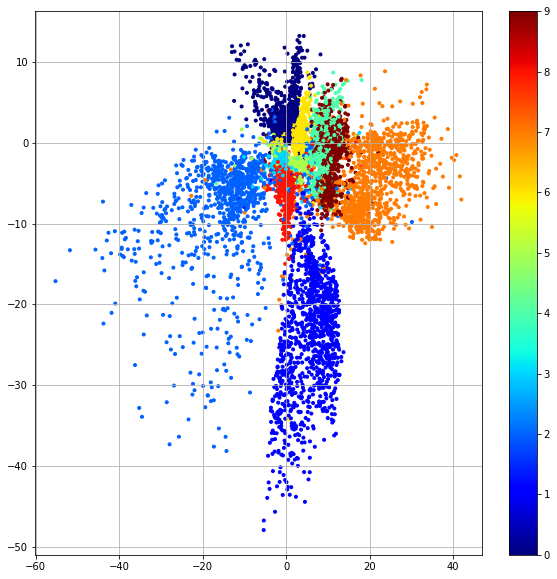

In [8]:
import pylab
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10, 10))
plt.scatter(z[:, 0], z[:, 1], marker='.', c=labels.numpy(), cmap=pylab.cm.jet)
plt.colorbar()
plt.grid()

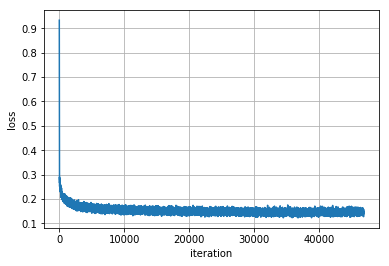

In [9]:
loss_list = np.load('{}/loss_list.npy'.format(out_dir))
plt.plot(loss_list)
plt.xlabel('iteration')
plt.ylabel('loss')
plt.grid()